Found 2527 images belonging to 6 classes.
Found 2527 images belonging to 6 classes.
Epoch 1/20


C:\Users\zidan\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


79/79 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.4537 - loss: 1.4715 - val_accuracy: 0.5726 - val_loss: 1.1697 - learning_rate: 1.0000e-04
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.7542 - loss: 0.7260 - val_accuracy: 0.5849 - val_loss: 1.1986 - learning_rate: 1.0000e-04
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.7998 - loss: 0.5921 - val_accuracy: 0.6435 - val_loss: 1.0339 - learning_rate: 1.0000e-04
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.8361 - loss: 0.5257 - val_accuracy: 0.6229 - val_loss: 1.2146 - learning_rate: 1.0000e-04
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.8418 - loss: 0.4792 - val_accuracy: 0.6015 - val_loss: 1.4271 - learning_rate: 1.0000e-04
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.8698 - loss: 0.4062 - val_accuracy: 0.6229 - val_loss: 1.2700 - learning_rate: 1.0000e-04
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.8817 - loss: 0.3

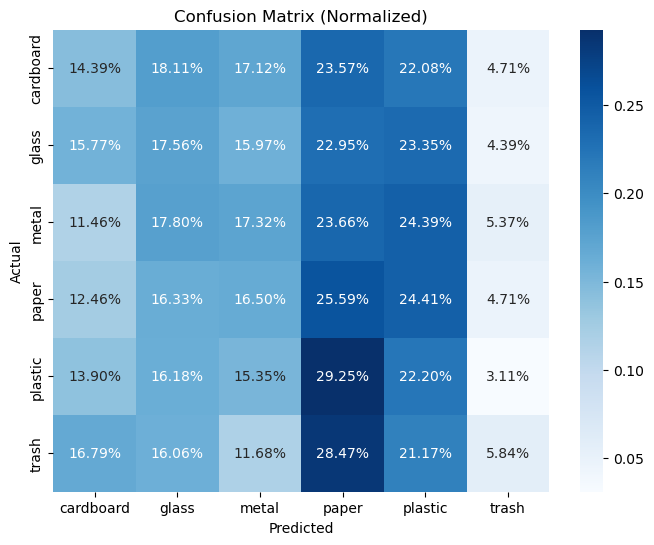

In [14]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix

# ==============================
# 📂 Dataset Path
# ==============================
dataset_path = r"C:\\Users\\zidan\\Desktop\\Coding\\PYTHON\\garbage_classification"
train_dir = os.path.join(dataset_path, "train")
validation_dir = os.path.join(dataset_path, "validation")

# ==============================
# 🎨 Data Augmentation
# ==============================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
validation_datagen = ImageDataGenerator(rescale=1./255)

# ==============================
# 🔄 Data Generators
# ==============================
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# ==============================
# 🏗️ Model Building (MobileNetV2)
# ==============================
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Fine-tune hanya 10 layer terakhir
for layer in base_model.layers[:-10]:
    layer.trainable = False
for layer in base_model.layers[-10:]:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.0001))(x)  # Regularization L2
x = Dropout(0.3)(x)  # Dropout 30% untuk mencegah overfitting
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# ==============================
# ⏳ Callbacks
# ==============================
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('GarbinetV1.keras', save_best_only=True, monitor='val_accuracy', mode='max')  # Save berdasarkan akurasi terbaik

callbacks = [early_stopping, reduce_lr, model_checkpoint]

# ==============================
# 🚀 Model Training
# ==============================
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=callbacks
)
model.save('GarbinetV1.keras')

# ==============================
# 📊 Evaluasi Model
# ==============================
def evaluate_model(model, validation_generator):
    Y_pred = model.predict(validation_generator)
    y_pred = np.argmax(Y_pred, axis=1)
    true_labels = validation_generator.classes

    print("\n📊 Classification Report:\n", classification_report(true_labels, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(true_labels, y_pred)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalized confusion matrix
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percentage, annot=True, fmt='.2%', cmap='Blues', xticklabels=validation_generator.class_indices, yticklabels=validation_generator.class_indices)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix (Normalized)')
    plt.show()

evaluate_model(model, validation_generator)

# ==============================
# 💾 Save Final Model
# ==============================
model.save("GarbinetV1_final.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


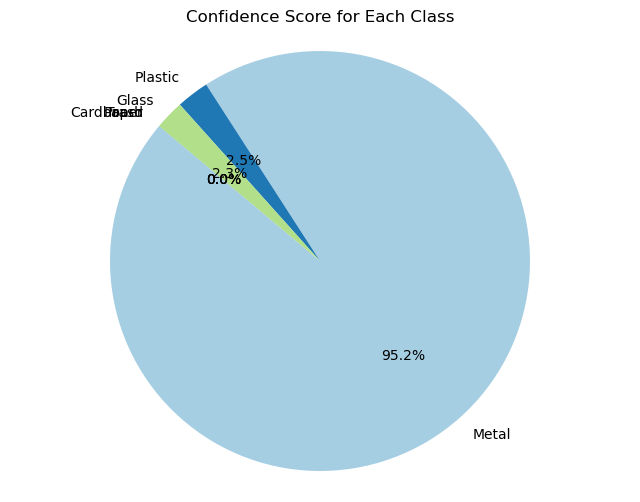

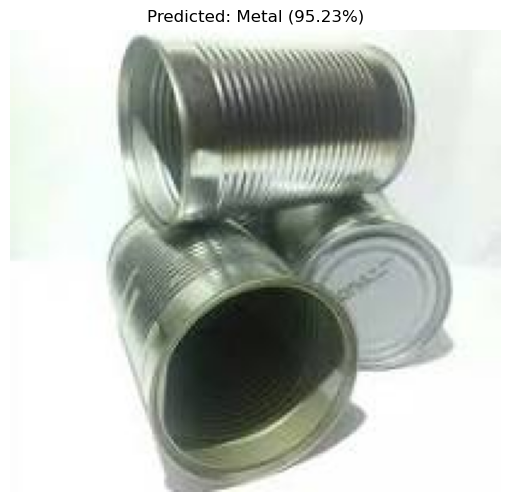

In [15]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from PyQt5.QtWidgets import QApplication, QFileDialog

# ==============================
# 🔍 Load Model
# ==============================
model = load_model('GarbinetV1_final.keras')
class_names = ["Cardboard", "Glass", "Metal", "Paper", "Plastic", "Trash"]

def detect_and_classify_trash(image):
    try:
        # Resize & Normalize Image
        resized_image = cv2.resize(image, (224, 224))
        normalized_image = resized_image.astype("float32") / 255.0
        input_image = np.expand_dims(normalized_image, axis=0)

        # Prediction
        predictions = model.predict(input_image)[0]
        predicted_index = np.argmax(predictions)
        predicted_label = class_names[predicted_index]

        # Sort Predictions for Visualization
        class_predictions = {class_names[i]: predictions[i] for i in range(len(class_names))}
        sorted_predictions = sorted(class_predictions.items(), key=lambda x: x[1], reverse=True)

        # 📊 Pie Chart
        labels, scores = zip(*sorted_predictions)
        plt.figure(figsize=(8, 6))
        plt.pie(scores, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
        plt.axis('equal')
        plt.title('Confidence Score for Each Class')
        plt.show()

        # 🖼️ Display Image with Prediction
        plt.figure(figsize=(8, 6))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(f'Predicted: {predicted_label} ({predictions[predicted_index]*100:.2f}%)')
        plt.axis('off')
        plt.show()
    
    except Exception as e:
        print(f"Error during classification: {e}")

def select_image():
    app = QApplication.instance()  # Check if QApplication already exists
    if not app:
        app = QApplication(sys.argv)
    
    file_path, _ = QFileDialog.getOpenFileName(None, "Pilih Gambar", "", "Image Files (*.png;*.jpg;*.jpeg;*.bmp)")
    
    if file_path:
        image = cv2.imread(file_path, cv2.IMREAD_COLOR)
        if image is None:
            print(f"❌ Failed to load image: {file_path}")
        else:
            detect_and_classify_trash(image)
    
    app.quit()

# Jalankan untuk memilih gambar
if __name__ == '__main__':
    select_image()